<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/High_Resolution_Daytime_Translation_(RUS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+4">Быстрая смена времени суток</font></b>

<b><font color="black" size="+2">Основан на:</font></b>

**GitHub репозитории**: [HiDT](https://github.com/saic-mdal/HiDT)

**Статья**: [High-Resolution Daytime Translation Without Domain Labels](https://arxiv.org/abs/2003.08791)

**Авторы**: Anokhin Ivan, Solovev Pavel, Korzhenkov Denis, Kharlamov Alexey, Khakhulin Taras, Silvestrov Alexey, Nikolenko Sergey, Lempitsky Victor, Sterkin Gleb

<b><font color="black" size="+2">Colab собрал:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

```
Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Устанавливаем все необходимые компоненты</font></b>

%cd /content
!rm -rf sample_data
!git clone https://github.com/saic-mdal/HiDT.git

import argparse
import glob
import os
import sys
sys.path.append('./HiDT')

import torch
from PIL import Image
from torchvision import transforms
from IPython.display import clear_output
from google.colab import files
from tqdm import tqdm

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing


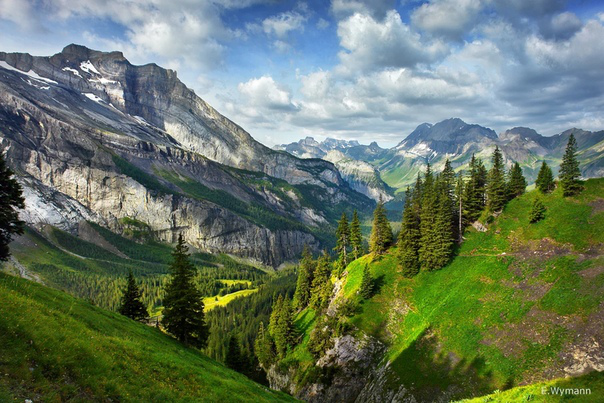

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Загружаем фото</font></b>

#@markdown *Ниже введите ссылку на фото, либо оставьте поле **source_url** пустым (в таком случае будет предложено загрузить фото с компьютера).*
source_url = 'https://sun9-40.userapi.com/c857520/v857520573/14d548/ECM-BPetXC4.jpg' #@param {type:"string"}
!rm -rf $pic_name

if source_url == '':
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  os.rename(fn, fn.replace(" ", ""))
  fn = fn.replace(" ", "")
  pic_name = "photo." + fn.split(".")[-1]
  !mv -f $fn $pic_name
else:
  try:
    pic_name = "photo." + source_url.split('.')[-1]
    !wget $source_url -O $pic_name
  except BaseException:
    print('Что-то пошло не так. Попробуйте загрузить фото с компьютера.')


config_path = './HiDT/configs/daytime.yaml'
gen_weights_path = './HiDT/trained_models/generator/daytime.pt'
inference_size = 256  # the network has been trained to do inference in 256px, any higher value might lead to artifacts
device = 'cuda:0'
image_path = '/content/photo.jpg'
styles_path = './HiDT/styles.txt'
enhancer_weights = './HiDT/trained_models/enhancer/enhancer.pth'

style_transformer = StyleTransformer(config_path,
                                     gen_weights_path,
                                     inference_size=inference_size,
                                     device=device)
with open(styles_path) as f:
    styles = f.read()
styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}
image = Image.open(image_path)
crop_transform = GridCrop(4, 1, hires_size=inference_size * 4)

clear_output()
image
#@markdown *Если при выполнении возникнет ошибка, то запустите этот блок заново*

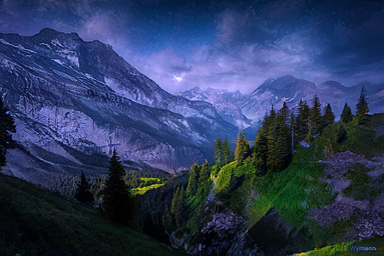

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Меняем стиль изображения</font></b>

# ----- Доступные стили -----
# print(list(styles.keys()))
# ---------------------------

#@markdown **Выберите время суток:**

#@markdown * *день* - day, hard_day, semihard_day

#@markdown * *закат* - sunset_hard_harder, presunset

#@markdown * *ночь* - 5minute, bluehour_hard, night

#@markdown * и прочие...

#@markdown ---
style = 'bluehour_hard' #@param ['hard_day', 'semihard_day', 'day', 'day2', 'presunset', 'sunset_hard_harder', 'sunsetred', '2minute', '5minute', '5minutes2', 'bluehour_hard', 'bluehour_bit_dark', 'night', 'night2', 'darknight', 'another_night', 'onemorenight', 'nightmore']
#@markdown ---
# Select the style, or define any vector you want
style_to_transfer = styles[style]

style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
with torch.no_grad():
    content_decomposition = style_transformer.get_content(image)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

clear_output()
transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)

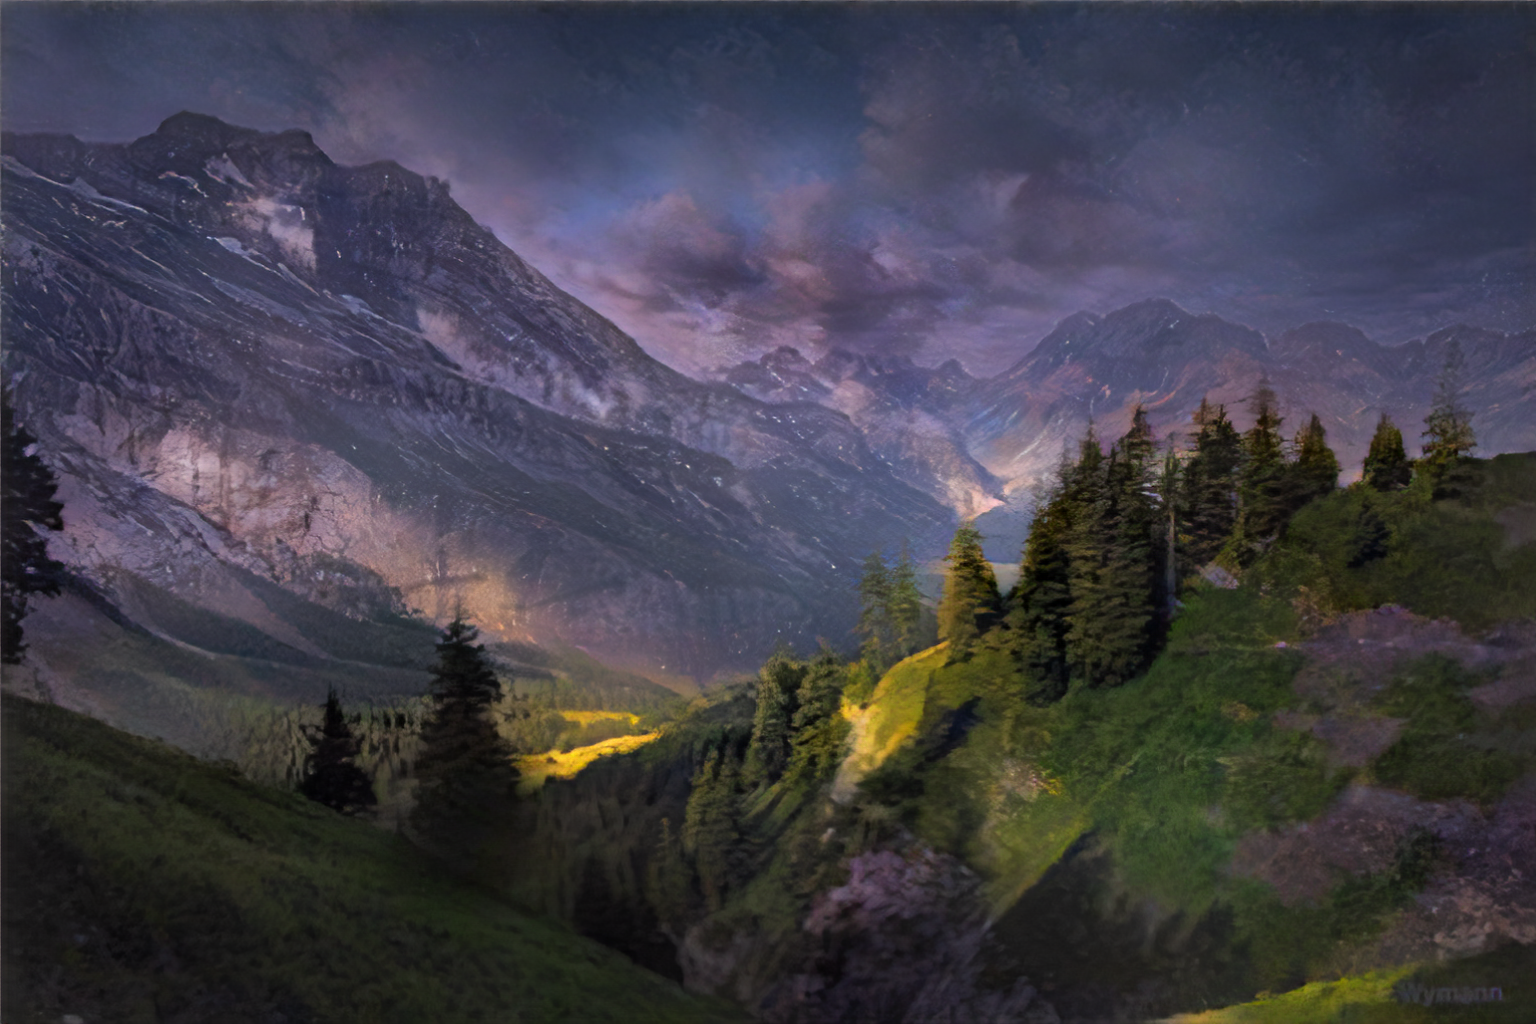

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Получить изображение в высоком разрешении</font></b>
#@markdown *Если хотите скачать изображение, ткните по нему правой кнопкой мыши и выберите "Сохранить изображение как..."*


enhancer = RRDBNet(in_nc=48, out_nc=3, nf=64, nb=5, gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))
with torch.no_grad():
    crops = [img for img in crop_transform(image)]
    content_decomposition = style_transformer.get_content(crops)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer.repeat(16, 1, 1, 1)}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']
    padded_stack = enhancement_preprocessing(transferred, normalize=False)
    out = enhancer(padded_stack)

transforms.ToPILImage()((out.cpu()[0].clamp(-1, 1) + 1.) / 2.)